In [174]:
# import libraries
import os, zipfile
import numpy as np
import pandas as pd
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

!pip install transformers
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.utils import to_categorical

from transformers import RobertaConfig, TFRobertaModel, RobertaTokenizerFast, TFRobertaForSequenceClassification

from sklearn.model_selection import train_test_split

In [175]:
# read in data
url = 'https://raw.githubusercontent.com/ziwei-z/w266-project/main/data/en-annotated.tsv'
data = pd.read_csv(url, sep='\t', header=None, names=['sentence', 'label_raw'])

# make flag for each emotion
emotions = ['anger', 'anticipation', 'digust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
i = 1
for emo in emotions:
  data[emo] = data.label_raw.str.contains(str(i))*1
  i += 1

data['label'] = [y[2:].astype('float32') for (x, y) in enumerate(data.values)]
data.head()

train_X, test_X, train_Y, test_Y = train_test_split(data['sentence'], data['label'], test_size = 0.2, random_state=13)
train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, test_size = 0.25, random_state=13)

train_Y = np.concatenate([[train_Y.iloc[x] for x in list(range(len(train_Y)))]])
test_Y = np.concatenate([[test_Y.iloc[x] for x in list(range(len(test_Y)))]])
dev_Y = np.concatenate([[dev_Y.iloc[x] for x in list(range(len(dev_Y)))]])

data.head(10)

,sentence,label_raw,anger,anticipation,digust,fear,joy,sadness,surprise,trust,label
0,", ...",1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,!,"1, 4, 7",1,0,0,1,0,0,1,0,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
2,... And I don't think we need to discuss the Trinity any more .,"8, 1",1,0,0,0,0,0,0,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,* So get up out of your bed,1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,A confession that you hired [PERSON] ... and are responsible for my father's murder .,"1, 6",1,0,0,0,0,1,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
5,A dead man has one half - hour to raise his roll outside and get back in the game .,1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,A guy that's talking about he's gonna solve all your problems .,1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,A guy who was a pain in the neck even before I carried his stuff .,1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,"A hundred of these are produced every day and sent to sweatshops where urban slaves prepare this poison for our friends , our loved ones , our children .","1, 3",1,0,1,0,0,0,0,0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,A lady wouldn't work for this outfit .,1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [176]:
# tabulate frequency of each label
print(sum(data.label).astype('int'))
print(sum(data.label).astype('int') / sum(sum(data.label).astype('int')))

[3828 3400 2317 2439 2833 2464 2442 2699]
[0.17072518 0.15163679 0.10333601 0.10877709 0.12634912 0.10989207
 0.10891089 0.12037285]


In [177]:
#examples 
random_ids = np.random.choice(len(data), replace = True, size = 10)
for id in random_ids:
  print(data.sentence.iloc[id], '             ', data.label_raw[id])


For far too long .               3
I like the bubble . - Yeah ?               7
Do you remember what sins ?               2
We're the only ones who can afford to be honest .               1
You can beat it out of me , but it won't do you any good .               1
Five years ago . Bingo .               7
You want to come into this house , you ring the damn bell !               1
What you did to me all those years ago .               1, 3
I might do that .               8, 7
In the ring , it's like all I see is him .               2


In [178]:
model_name = 'roberta-base'

# Max length of tokens
max_length = 100

# Load transformers config
config = RobertaConfig.from_pretrained(model_name)

# Load BERT tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", config = config)
config.output_hidden_states = False

# Load the Transformers BERT model
transformer_model = TFRobertaModel.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
#transformer_model = TFRobertaForSequenceClassification.from_pretrained(pretrained_model_name_or_path = model_name, config = config)


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [179]:
# look at the configuration
config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [180]:
# Load the MainLayer
roberta = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = input_ids

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
outputs = Dense(units=8, kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
                activation = 'sigmoid')(pooled_output)

# And combine it all in a model object
model = Model(inputs=input_ids, outputs=outputs, name='RoBERTa_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

# Tokenize the input (takes some time)
def tokenize(data):
    return tokenizer(
          text=data.tolist(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding='max_length', 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)
    
# Set an optimizer
optimizer = Adam(
    learning_rate=8e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

x = tokenize(train_X)
x_dev = tokenize(dev_X)


# early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0)

Model: "RoBERTa_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 100)]             0         
                                                                 
 roberta (TFRobertaMainLayer  TFBaseModelOutputWithPoo  124645632
 )                           lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             100, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                     

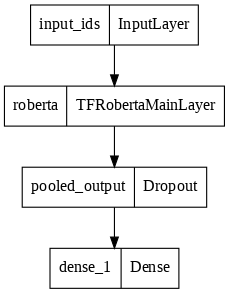

In [181]:
tf.keras.utils.plot_model(model, dpi=80)

In [182]:
# Fit the model - don't run every time
# history = model.fit(
#     x=x['input_ids'],
#     y=train_Y,
#     #validation_split = 0.2,
#     validation_data=(x_dev['input_ids'], dev_Y),
#     batch_size=64,
#     epochs=5,
#     callbacks=[callback])

In [183]:
# from google.colab import drive
# drive.mount('/content/drive')

In [184]:
#save model
path = "/content/drive/MyDrive/W266 Project/saved models/roberta_cls_5e-5_64_weights.h5"

#model.save_weights(path)

model.load_weights(path)

In [185]:
#graph 
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper right')
# plt.show()

In [186]:
#evaluate

x_test = tokenize(test_X)

# # Run evaluation
# model_eval = model.evaluate(
#     x=x_test['input_ids'],
#     y=to_categorical(test_Y)
# )

In [187]:
y_pred=model.predict(x_test['input_ids'])
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid

In [213]:
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

print('accuracy_score', accuracy_score(y_pred_bool, test_Y))
print('hamming loss  ', hamming_loss(y_pred_bool, test_Y))
print('hamming score ', hamming_score(test_Y, y_pred_bool))

accuracy_score 0.41186537364517967
hamming loss   0.12949229891614375
hamming score  0.49984787982506174


In [189]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
print(classification_report(test_Y, y_pred_bool, digits = 3, target_names = emotions))

              precision    recall  f1-score   support

       anger      0.614     0.474     0.535       775
anticipation      0.644     0.444     0.526       633
     disgust      0.562     0.433     0.489       460
        fear      0.632     0.464     0.535       500
         joy      0.717     0.606     0.657       592
     sadness      0.648     0.485     0.555       464
    surprise      0.568     0.446     0.499       505
       trust      0.593     0.473     0.527       564

   micro avg      0.625     0.480     0.543      4493
   macro avg      0.622     0.478     0.540      4493
weighted avg      0.624     0.480     0.542      4493
 samples avg      0.574     0.525     0.531      4493



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [190]:
# how many have no predicted labels
num_labels_predicted = pd.Series(np.sum(y_pred_bool,axis=1))
num_labels_predicted.value_counts()


1    2885
0     339
2     282
dtype: int64

In [191]:
# for ones without any labels predicted, change prediction to the label with highest prob. 
y_pred_bool_filled = (y_pred>0.5)*1
for x in range(len(test_Y)):
  if sum(y_pred_bool_filled[x])==0:
    index_label_highest_prob = y_pred[x].argmax()
    y_pred_bool_filled[x][index_label_highest_prob] = 1 

In [192]:
num_labels_predicted_filled = pd.Series(np.sum(y_pred_bool_filled,axis=1))
num_labels_predicted_filled.value_counts()

1    3224
2     282
dtype: int64

In [218]:
print('accuracy_score', accuracy_score(y_pred_bool_filled, test_Y))
print('hamming loss  ', hamming_loss(test_Y, y_pred_bool_filled))
print('hamming score ', hamming_score(test_Y, y_pred_bool_filled))

print(classification_report(test_Y, y_pred_bool_filled, digits = 3, target_names = emotions))

accuracy_score 0.4306902452937821
hamming loss   0.13352110667427267
hamming score  0.5249952462445332
              precision    recall  f1-score   support

       anger      0.592     0.514     0.550       775
anticipation      0.626     0.468     0.535       633
     disgust      0.542     0.450     0.492       460
        fear      0.604     0.488     0.540       500
         joy      0.692     0.625     0.657       592
     sadness      0.603     0.500     0.547       464
    surprise      0.533     0.469     0.499       505
       trust      0.577     0.504     0.538       564

   micro avg      0.599     0.505     0.548      4493
   macro avg      0.596     0.502     0.545      4493
weighted avg      0.599     0.505     0.547      4493
 samples avg      0.606     0.550     0.559      4493



In [238]:
for x in [3155]:
  print(x, accuracy_score([test_Y[x]], [y_pred_bool[x]]), test_Y[x], y_pred_bool_filled[x], test_X.iloc[x])

3155 0.0 [1. 0. 0. 0. 0. 0. 0. 0.] [0 0 0 0 0 1 0 0] You've gone out of your mind .


In [237]:
print(y_pred[3155])

[0.20777461 0.02592069 0.43240994 0.13033524 0.00977135 0.4368639
 0.43269837 0.01610047]


In [195]:
# index of cases where digust is a true label but it is not predicted
index = []
for x in range(len(test_Y)):
    if test_Y[x][2]==1 and y_pred_bool_filled[x][2]==0:
      index.append(x)

In [196]:
# errors [ index, emotion that was a true label but wasn't predicted, label with the highest probability ]
errors = []
for ind in range(len(test_Y)):
  for emotion in range(8):
    if test_Y[ind][emotion]==1 and y_pred_bool_filled[ind][emotion]==0:
      label_highest_prob = y_pred[ind].argmax()
      errors.append([ind, emotion, label_highest_prob])

In [198]:
d = {'test_index': [x[0] for x in errors], 'true_label': [x[1] for x in errors],  'label_highest_prob': [x[2] for x in errors] }
df = pd.DataFrame(data=d)
df['sentence'] = df.apply(lambda row: test_X.iloc[row.test_index], axis=1)
df.head()

,test_index,true_label,label_highest_prob,sentence
0,3,7,0,You know what I'm talking about .
1,5,1,0,And you're gonna ask me questions .
2,5,3,0,And you're gonna ask me questions .
3,8,1,0,"Which we don't care about losing , by the way ."
4,8,7,0,"Which we don't care about losing , by the way ."


In [199]:
df2 = df.groupby(['true_label', 'label_highest_prob']).count().reset_index().drop(columns =['test_index'])
df2.head()

,true_label,label_highest_prob,sentence
0,0,1,35
1,0,2,89
2,0,3,41
3,0,4,23
4,0,5,69


In [200]:
df3 = df2.pivot_table(values=['sentence'], columns='label_highest_prob', index='true_label').reset_index().fillna(0)
df3

true_label sentence              ...                        
label_highest_prob                   0     1     2  ...     4     5     6     7
0                           0      0.0  35.0  89.0  ...  23.0  69.0  74.0  46.0
1                           1     63.0   0.0  12.0  ...  70.0  13.0  91.0  59.0
2                           2     86.0  13.0   0.0  ...  19.0  45.0  42.0  24.0
3                           3     73.0  29.0  24.0  ...  10.0  48.0  52.0  20.0
4                           4     18.0  59.0   9.0  ...   0.0  11.0  32.0  81.0
5                           5     48.0  15.0  38.0  ...  19.0   0.0  33.0  23.0
6                           6     54.0  21.0  33.0  ...  44.0  40.0   0.0  32.0
7                           7     56.0  73.0  11.0  ...  73.0  29.0  17.0   0.0

[8 rows x 9 columns]

In [201]:
con_mat = np.zeros(shape=(8,8))
type(con_mat)
for i in range(len(con_mat)):
  con_mat[i] = df3.to_numpy()[i][1::]
con_mat

array([[ 0., 35., 89., 41., 23., 69., 74., 46.],
       [63.,  0., 12., 29., 70., 13., 91., 59.],
       [86., 13.,  0., 24., 19., 45., 42., 24.],
       [73., 29., 24.,  0., 10., 48., 52., 20.],
       [18., 59.,  9., 12.,  0., 11., 32., 81.],
       [48., 15., 38., 56., 19.,  0., 33., 23.],
       [54., 21., 33., 44., 44., 40.,  0., 32.],
       [56., 73., 11., 21., 73., 29., 17.,  0.]])

In [202]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_norm

array([[0.  , 0.09, 0.24, 0.11, 0.06, 0.18, 0.2 , 0.12],
       [0.19, 0.  , 0.04, 0.09, 0.21, 0.04, 0.27, 0.18],
       [0.34, 0.05, 0.  , 0.09, 0.08, 0.18, 0.17, 0.09],
       [0.29, 0.11, 0.09, 0.  , 0.04, 0.19, 0.2 , 0.08],
       [0.08, 0.27, 0.04, 0.05, 0.  , 0.05, 0.14, 0.36],
       [0.21, 0.06, 0.16, 0.24, 0.08, 0.  , 0.14, 0.1 ],
       [0.2 , 0.08, 0.12, 0.16, 0.16, 0.15, 0.  , 0.12],
       [0.2 , 0.26, 0.04, 0.08, 0.26, 0.1 , 0.06, 0.  ]])

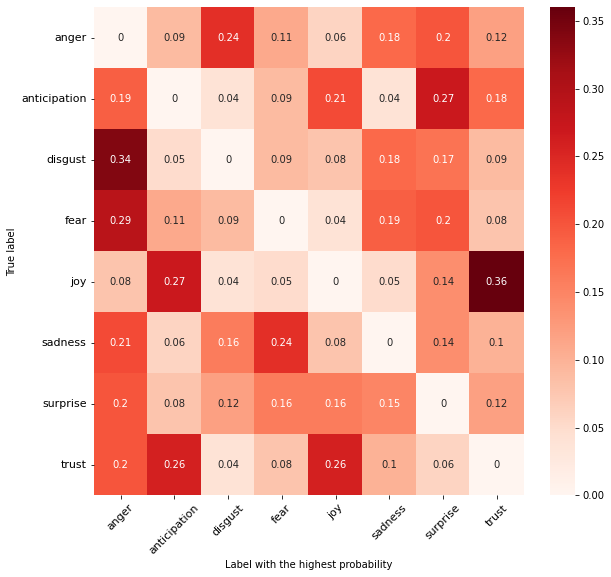

In [258]:
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = emotions, 
                     columns = emotions)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Label with the highest probability')
plt.xticks(rotation=45, size=11)
plt.yticks(rotation=360, size=11)
plt.show()
figure.savefig('/content/drive/MyDrive/W266 Project/confusion-matrix.png')

In [259]:
pd.set_option("max_colwidth", 400)
df[(df.true_label==0) & ((df.label_highest_prob==5) | (df.label_highest_prob==5))]

,test_index,true_label,label_highest_prob,sentence
10,16,0,5,It wasn't worth it .
13,22,0,5,"We can't cover for him , [PERSON] ."
39,59,0,5,It's just beginner's luck .
65,100,0,5,Then you don't approve .
82,127,0,5,As am I . The black community deserves so much better than [PERSON]'s failed policies .
...,...,...,...,...
2004,3155,0,5,You've gone out of your mind .
2021,3186,0,5,"You let me down , [PERSON] ."
2091,3293,0,5,"I am the medical examiner and the chief pathologist in the city , and they've cut me out ."
2137,3367,0,5,Nothing .
